In [5]:
# Base import and functions

import imutils
import cv2
from imutils import contours
import os, os.path

from tqdm import tqdm

import pytesseract             # Python interface to tesseract for OCR

import numpy as np
from PIL import Image

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [13]:
def build_segmentation_row(filesconut, current_file_index, fig, input_src, serial, number, barcode):
    
    a = fig.add_subplot(filescount, 4, 4 * current_file_index + 1)
    imgplot = plt.imshow(cv2.cvtColor(input_src, cv2.COLOR_BGR2RGB))
    a.set_title('Original')

    a = fig.add_subplot(filescount, 4, 4 * current_file_index + 2)
    imgplot = plt.imshow(cv2.cvtColor(serial, cv2.COLOR_GRAY2RGB))
    a.set_title('Serial')

    a = fig.add_subplot(filescount, 4, 4 * current_file_index + 3)
    imgplot = plt.imshow(cv2.cvtColor(number, cv2.COLOR_GRAY2RGB))
    a.set_title('Number')

    a = fig.add_subplot(filescount, 4, 4 * current_file_index + 4)
    imgplot = plt.imshow(cv2.cvtColor(barcode, cv2.COLOR_GRAY2RGB))
    a.set_title('Barcode')
    
def build_contoured_row(filesconut, current_file_index, fig, input_src, serial, number, barcode):
    
    a = fig.add_subplot(filescount, 4, 4 * current_file_index + 1)
    imgplot = plt.imshow(cv2.cvtColor(input_src, cv2.COLOR_BGR2RGB))
    a.set_title('Original')

    a = fig.add_subplot(filescount, 4, 4 * current_file_index + 2)
    imgplot = plt.imshow(cv2.cvtColor(serial, cv2.COLOR_BGR2RGB))
    a.set_title('Serial')

    a = fig.add_subplot(filescount, 4, 4 * current_file_index + 3)
    imgplot = plt.imshow(cv2.cvtColor(number, cv2.COLOR_BGR2RGB))
    a.set_title('Number')

    a = fig.add_subplot(filescount, 4, 4 * current_file_index + 4)
    imgplot = plt.imshow(cv2.cvtColor(barcode, cv2.COLOR_GRAY2RGB))
    a.set_title('Barcode')

CPU times: user 112 ms, sys: 0 ns, total: 112 ms
Wall time: 85.2 ms


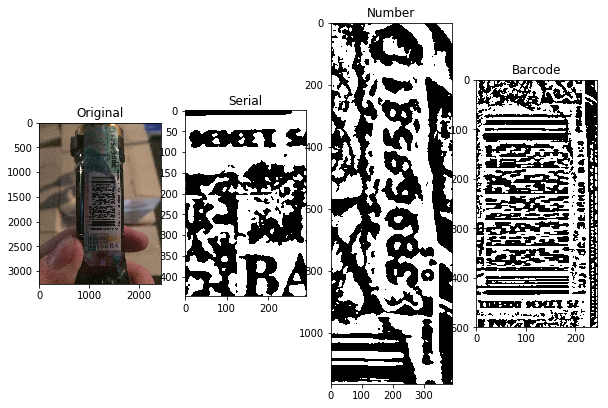

In [97]:
def excise_segmentation(image):
    
    number = image[78:78+1166, 1276:1276+392]
    serial = image[2088:2088+448, 1276:1276+292]
   
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    
    # Serial
    hsv_image = cv2.cvtColor(serial, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_image)
    v = clahe.apply(v)
    blurred = cv2.bilateralFilter(v, 9, 75, 75)
    blurred = cv2.medianBlur(blurred, 5)
    serial_thresholded = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 255, 1)
    
    edged = cv2.Canny(serial_thresholded, 30, 200)
    refCnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    serial_contours = np.dstack([serial_thresholded.copy()] * 3)
    for c in refCnts:
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(serial_contours, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Number
    hsv_image = cv2.cvtColor(number, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_image)
    v = clahe.apply(v)
    blurred = cv2.bilateralFilter(v, 9, 75, 75)
    blurred = cv2.medianBlur(blurred, 5)
    number_thresholded = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 195, 1)
    
    edged = cv2.Canny(number_thresholded, 30, 200)
    refCnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    number_contours = np.dstack([number_thresholded.copy()] * 3)
    for c in refCnts:
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(number_contours, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Barcode
    barcode_thresholded = image[880:880+1408, 828:828+868]
    barcode = imutils.resize(image[880:880+1408, 828:828+868], height=500)
    hsv_image = cv2.cvtColor(barcode, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_image)
    gray = clahe.apply(v)
    gradX = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx = 1, dy = 0, ksize = -1)
    gradY = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx = 0, dy = 1, ksize = -1)
    gradient = cv2.subtract(gradX, gradY)
    gradient = cv2.convertScaleAbs(gradient)
    blurred = cv2.medianBlur(gradient, 11)
    (_, thresh) = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    morph = cv2.erode(closed, None, iterations = 11)
    cnts = cv2.findContours(morph.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    if len(cnts):
        c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
        (x, y, w, h) = cv2.boundingRect(c)
        # PDF417 correction
        x = x - 10 if (x > 10) else 0
        w = w + 20 if (w < 868 - x - 20) else 868 - x
        # Top and bottom black line in PDF417
        y = y - (int)(0.3 * h) if (y > 0.3 * h) else 0
        h = h + (int)(0.5 * h) if (h < 1408 - y - (int)(0.6 * h)) else 1408 - y        
        hsv_image = cv2.cvtColor(barcode[y:y+h, x:x+w], cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(hsv_image)
        gray = clahe.apply(v)
        blured = cv2.medianBlur(gray, 3)
        barcode_thresholded = cv2.adaptiveThreshold(blured, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 1)        
 
    # return the segmentationed images
    return serial_thresholded, number_thresholded, barcode_thresholded
    # return serial_contours, number_contours, barcode_thresholded
    # return serial_thresholded, number_contours, barcode_thresholded

excise_src = cv2.imread("data/premasked/IMG_0676.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0549.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0560.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0562.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0595.JPG")
filescount = 1
current_file_index = 0
fig = plt.figure(figsize=(10, 200))
%time serial_thresholded, number_thresholded, barcode_thresholded = excise_segmentation(excise_src)

build_segmentation_row(filescount, current_file_index, fig, excise_src, serial_thresholded, number_thresholded, barcode_thresholded)
# build_contoured_row(filescount, current_file_index, fig, excise_src, serial_thresholded, number_thresholded, barcode_thresholded)

plt.show()

# Another brightness correction

/home/levabd/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


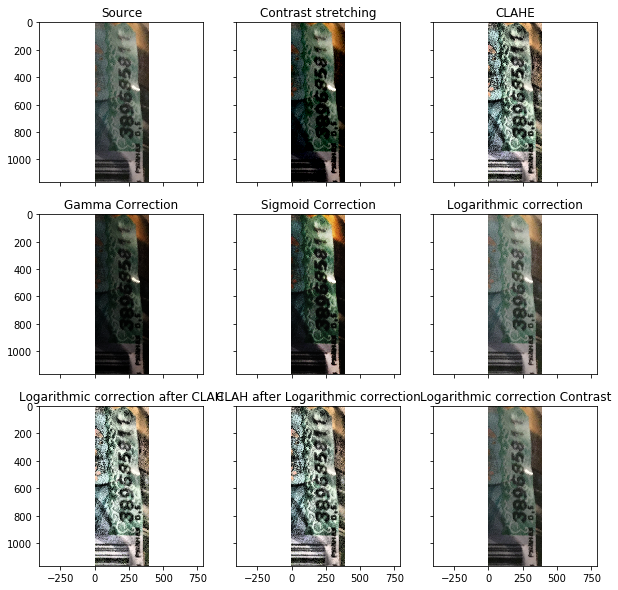

In [122]:
from skimage.exposure import equalize_adapthist, rescale_intensity, adjust_gamma, adjust_sigmoid, adjust_log, is_low_contrast

src = Image.open('data/premasked/IMG_0676.JPG')
# src = Image.open('data/premasked/IMG_0549.JPG')
# src = Image.open('data/premasked/IMG_0560.JPG')
# src = Image.open('data/premasked/IMG_0562.JPG')
# src = Image.open('data/premasked/IMG_0595.JPG')

image = src.rotate(-90, expand=True).crop((1276, 78, 1276+392, 78+1166))
width = image.size[0]
height = image.size[1]
# image = image.resize(((int)(width * 500 / height), 500), Image.ANTIALIAS)

img = img_as_float(image)

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
imagecs = rescale_intensity(img, in_range=(p02, p098))

# CLAHE
img_adapteq = equalize_adapthist(img, clip_limit=0.03)

# Gamma Correction
gamma_corrected = adjust_gamma(img, 2)

# Logarithmic
logarithmic_corrected = adjust_log(img, 1)

# Sigmoid
sigmoid_corrected = adjust_sigmoid(img, cutoff=0.5, gain=10, inv=False)

img_clah_log = adjust_log(img_adapteq, 1)
logarithmic_corrected = adjust_log(img, 1)  # <-- !!!!!!!!!!
img_log_clah = equalize_adapthist(logarithmic_corrected, clip_limit=0.03)  # <-- !!!!!!!!!!
p2, p98 = np.percentile(logarithmic_corrected, (2, 98))
img_cs_log = rescale_intensity(logarithmic_corrected, in_range=(p02, p098))

dims, rows, cols = img.shape

fig, ax = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(image)
ax[0, 0].set_title("Source")
ax[0, 1].imshow(imagecs)
ax[0, 1].set_title('Contrast stretching')
ax[0, 2].imshow(img_adapteq)
ax[0, 2].set_title('CLAHE')
ax[1, 0].imshow(gamma_corrected)
ax[1, 0].set_title('Gamma Correction')
ax[1, 1].imshow(sigmoid_corrected)
ax[1, 1].set_title('Sigmoid Correction')
ax[1, 2].imshow(logarithmic_corrected)
ax[1, 2].set_title('Logarithmic correction')
ax[2, 0].imshow(img_clah_log)
ax[2, 0].set_title('Logarithmic correction after CLAH')
ax[2, 1].imshow(img_log_clah)
ax[2, 1].set_title('CLAH after Logarithmic correction')  # <-- !!!!!!!!!!
ax[2, 2].imshow(img_cs_log)
ax[2, 2].set_title('Logarithmic correction Contrast')

plt.show()

## Another denoising

Total variation and bilateral algorithms typically produce “posterized” images with flat domains separated by sharp edges. It is possible to change the degree of posterization by controlling the tradeoff between denoising and faithfulness to the original image.

### Total variation filter
The result of this filter is an image that has a minimal total variation norm, while being as close to the initial image as possible. The total variation is the L1 norm of the gradient of the image.

### Bilateral filter
A bilateral filter is an edge-preserving and noise reducing filter. It averages pixels based on their spatial closeness and radiometric similarity.

### Wavelet denoising filter
A wavelet denoising filter relies on the wavelet representation of the image. The noise is represented by small values in the wavelet domain which are set to 0.

In color images, wavelet denoising is typically done in the YCbCr color space as denoising in separate color channels may lead to more apparent noise.

/home/levabd/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


CPU times: user 718 ms, sys: 0 ns, total: 718 ms
Wall time: 718 ms
CPU times: user 1min 13s, sys: 191 ms, total: 1min 13s
Wall time: 1min 13s
CPU times: user 129 ms, sys: 0 ns, total: 129 ms
Wall time: 129 ms
CPU times: user 1.89 s, sys: 0 ns, total: 1.89 s
Wall time: 1.89 s
CPU times: user 212 ms, sys: 0 ns, total: 212 ms
Wall time: 213 ms


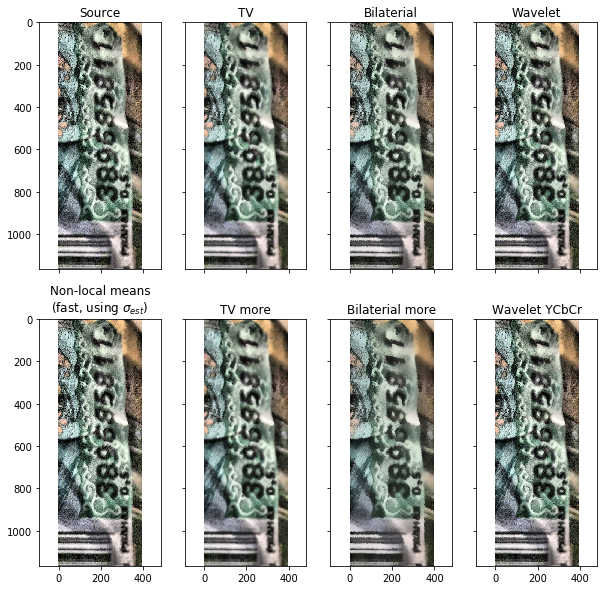

In [159]:
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral, denoise_wavelet, estimate_sigma, denoise_nl_means

src = Image.open('data/premasked/IMG_0676.JPG')
# src = Image.open('data/premasked/IMG_0549.JPG')
# src = Image.open('data/premasked/IMG_0560.JPG')
# src = Image.open('data/premasked/IMG_0562.JPG')
# src = Image.open('data/premasked/IMG_0595.JPG')

image = src.rotate(-90, expand=True).crop((1276, 78, 1276+392, 78+1166))
width = image.size[0]
height = image.size[1]

img = img_as_float(image)
logarithmic_corrected = adjust_log(img, 1)
img_log_clah = equalize_adapthist(logarithmic_corrected, clip_limit=0.03)

fig, ax = plt.subplots(2, 4, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(img_log_clah)
ax[0, 0].set_title("Source")
%time ax[0, 1].imshow(denoise_tv_chambolle(img_log_clah, weight=0.1, multichannel=True))  # <-- !!!!!!!!
ax[0, 1].set_title('TV')
%time ax[0, 2].imshow(denoise_bilateral(img_log_clah, sigma_color=0.05, sigma_spatial=15, multichannel=True))
ax[0, 2].set_title('Bilaterial')
%time ax[0, 3].imshow(denoise_wavelet(img_log_clah, multichannel=True))
ax[0, 3].set_title('Wavelet')
patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)
sigma_est = np.mean(estimate_sigma(img_log_clah, multichannel=True))
%time ax[1, 0].imshow(denoise_nl_means(img_log_clah, h=0.6 * sigma_est, fast_mode=True, **patch_kw))
ax[1, 0].set_title('Non-local means\n(fast, using $\sigma_{est}$)')
ax[1, 1].imshow(denoise_tv_chambolle(img_log_clah, weight=0.2, multichannel=True))
ax[1, 1].set_title('TV more')
ax[1, 2].imshow(denoise_bilateral(img_log_clah, sigma_color=0.1, sigma_spatial=15, multichannel=True))
ax[1, 2].set_title('Bilaterial more')
%time ax[1, 3].imshow(denoise_wavelet(img_log_clah, multichannel=True, convert2ycbcr=True)) # <-- !!!!!!!!
ax[1, 3].set_title('Wavelet YCbCr')

plt.show()

## Wavelet fasters and best

## Filtering regional maxima

Here, we use morphological reconstruction to create a background image, which we can subtract from the original image to isolate bright features (regional maxima).

First we try reconstruction by dilation starting at the edges of the image. We initialize a seed image to the minimum intensity of the image, and set its border to be the pixel values in the original image. These maximal pixels will get dilated in order to reconstruct the background image.

/home/levabd/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


CPU times: user 850 ms, sys: 64 ms, total: 914 ms
Wall time: 824 ms


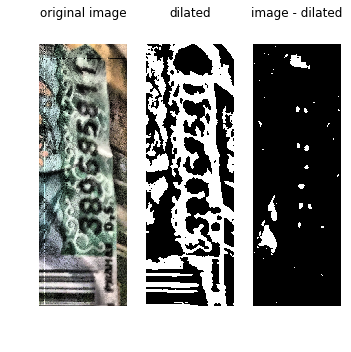

In [160]:
%%time

from skimage.morphology import reconstruction

src = Image.open('data/premasked/IMG_0676.JPG')
# src = Image.open('data/premasked/IMG_0549.JPG')
# src = Image.open('data/premasked/IMG_0560.JPG')
# src = Image.open('data/premasked/IMG_0562.JPG')
# src = Image.open('data/premasked/IMG_0595.JPG')

image = src.rotate(-90, expand=True).crop((1276, 78, 1276+392, 78+1166))
width = image.size[0]
height = image.size[1]

img = img_as_float(image)
logarithmic_corrected = adjust_log(img, 1)
img_log_clah = equalize_adapthist(logarithmic_corrected, clip_limit=0.03)
denoised = denoise_wavelet(img_log_clah, multichannel=True, convert2ycbcr=True)

seed = np.copy(number_thresholded)
seed[1:-1, 1:-1] = number_thresholded.min()
mask = number_thresholded

dilated = reconstruction(seed, mask, method='dilation')

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=3,
                                    figsize=(5, 5),
                                    sharex=True,
                                    sharey=True)

ax0.imshow(denoised, cmap='gray')
ax0.set_title('original image')
ax0.axis('off')

ax1.imshow(dilated, vmin=denoised.min(), vmax=denoised.max(), cmap='gray')
ax1.set_title('dilated')
ax1.axis('off')

ax2.imshow(number_thresholded - dilated, cmap='gray')
ax2.set_title('image - dilated')
ax2.axis('off')

fig.tight_layout()

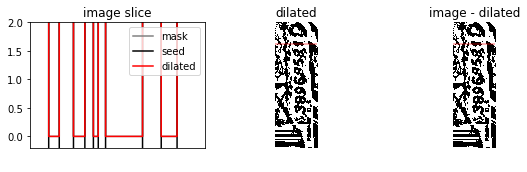

In [139]:
h = 0.4
seed = number_thresholded - h
dilated = reconstruction(seed, mask, method='dilation')
hdome = number_thresholded - dilated

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(8, 2.5))
yslice = 197

ax0.plot(mask[yslice], '0.5', label='mask')
ax0.plot(seed[yslice], 'k', label='seed')
ax0.plot(dilated[yslice], 'r', label='dilated')
ax0.set_ylim(-0.2, 2)
ax0.set_title('image slice')
ax0.set_xticks([])
ax0.legend()

ax1.imshow(dilated, vmin=number_thresholded.min(), vmax=number_thresholded.max(), cmap='gray')
ax1.axhline(yslice, color='r', alpha=0.4)
ax1.set_title('dilated')
ax1.axis('off')

ax2.imshow(hdome, cmap='gray')
ax2.axhline(yslice, color='r', alpha=0.4)
ax2.set_title('image - dilated')
ax2.axis('off')

fig.tight_layout()
plt.show()

## Filling holes and finding peaks
We fill holes (i.e. isolated, dark spots) in an image using morphological reconstruction by erosion. Erosion expands the minimal values of the seed image until it encounters a mask image. Thus, the seed image and mask image represent the maximum and minimum possible values of the reconstructed image.

We start with an image containing both peaks and holes:

/home/levabd/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


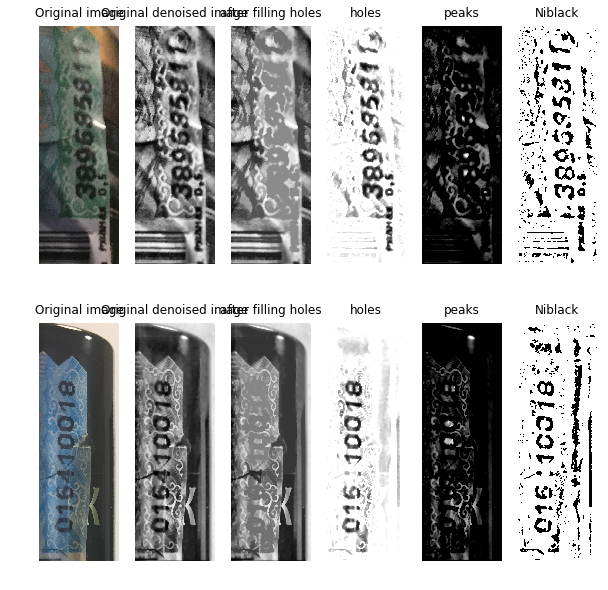

CPU times: user 5.9 s, sys: 316 ms, total: 6.22 s
Wall time: 5.82 s


In [171]:
%%time

from skimage.morphology import reconstruction
from skimage.color import rgb2gray
from skimage.filters import threshold_niblack

src = Image.open('data/premasked/IMG_0676.JPG')
src2 = Image.open('data/premasked/IMG_0549.JPG')
# src = Image.open('data/premasked/IMG_0560.JPG')
# src = Image.open('data/premasked/IMG_0562.JPG')
# src = Image.open('data/premasked/IMG_0595.JPG')

# First source
image = src.rotate(-90, expand=True).crop((1276, 78, 1276+392, 78+1166))
width = image.size[0]
height = image.size[1]

img = img_as_float(image)
logarithmic_corrected = adjust_log(img, 1)
img_log_clah = equalize_adapthist(logarithmic_corrected, clip_limit=0.03)
denoised = denoise_tv_chambolle(img_log_clah, weight=0.2, multichannel=True)
denoised_g = rgb2gray(denoised)

seed = np.copy(denoised_g)
seed[1:-1, 1:-1] = denoised_g.max()
mask = denoised_g

filled = reconstruction(seed, mask, method='erosion')
holes = denoised_g-filled

seed = np.copy(denoised_g)
seed[1:-1, 1:-1] = denoised_g.min()
rec = reconstruction(seed, mask, method='dilation')

# Secong source
image2 = src2.rotate(-90, expand=True).crop((1276, 78, 1276+392, 78+1166))
width = image2.size[0]
height = image2.size[1]

img = img_as_float(image2)
logarithmic_corrected = adjust_log(img, 1)
img_log_clah = equalize_adapthist(logarithmic_corrected, clip_limit=0.03)
denoised = denoise_tv_chambolle(img_log_clah, weight=0.2, multichannel=True)
denoised_g2 = rgb2gray(denoised)

seed = np.copy(denoised_g2)
seed[1:-1, 1:-1] = denoised_g2.max()
mask = denoised_g2

filled2 = reconstruction(seed, mask, method='erosion')
holes2 = denoised_g2-filled2

seed = np.copy(denoised_g2)
seed[1:-1, 1:-1] = denoised_g2.min()
rec2 = reconstruction(seed, mask, method='dilation')

fig, ax = plt.subplots(2, 6, figsize=(10, 10), sharex=True, sharey=True)
ax = ax.ravel()

ax[0].imshow(image)
ax[0].set_title('Original image')
ax[0].axis('off')

ax[1].imshow(denoised_g, cmap='gray')
ax[1].set_title('Original denoised image')
ax[1].axis('off')

ax[2].imshow(filled, cmap='gray')
ax[2].set_title('after filling holes')
ax[2].axis('off')

ax[3].imshow(holes, cmap='gray')
ax[3].set_title('holes')
ax[3].axis('off')

ax[4].imshow(denoised_g-rec, cmap='gray')
ax[4].set_title('peaks')
ax[4].axis('off')

ax[5].imshow(holes > threshold_niblack(holes, window_size=91, k=0.8), cmap='gray')
ax[5].set_title('Niblack')
ax[5].axis('off')

ax[6].imshow(image2)
ax[6].set_title('Original image')
ax[6].axis('off')

ax[7].imshow(denoised_g2, cmap='gray')
ax[7].set_title('Original denoised image')
ax[7].axis('off')

ax[8].imshow(filled2, cmap='gray')
ax[8].set_title('after filling holes')
ax[8].axis('off')

ax[9].imshow(holes2, cmap='gray')
ax[9].set_title('holes')
ax[9].axis('off')

ax[10].imshow(denoised_g2-rec2, cmap='gray')
ax[10].set_title('peaks')
ax[10].axis('off')

ax[11].imshow(holes2 > threshold_niblack(holes2, window_size=91, k=0.8), cmap='gray')
ax[11].set_title('Niblack')
ax[11].axis('off')

plt.show()

## Threshold tests

/home/levabd/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


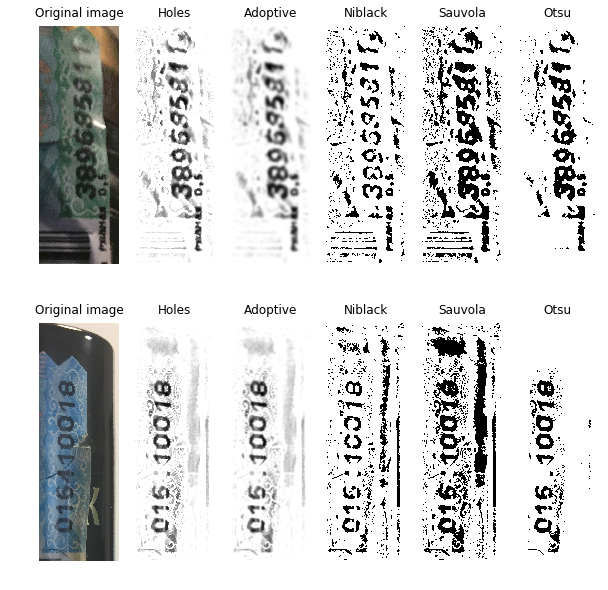

CPU times: user 12 s, sys: 304 ms, total: 12.3 s
Wall time: 12 s


In [180]:
%%time

from skimage.morphology import reconstruction
from skimage.color import rgb2gray
from skimage.filters import threshold_niblack, threshold_otsu, threshold_local, threshold_sauvola

src = Image.open('data/premasked/IMG_0676.JPG')
src2 = Image.open('data/premasked/IMG_0549.JPG')
# src = Image.open('data/premasked/IMG_0560.JPG')
# src = Image.open('data/premasked/IMG_0562.JPG')
# src = Image.open('data/premasked/IMG_0595.JPG')

# First source
image = src.rotate(-90, expand=True).crop((1276, 78, 1276+392, 78+1166))
width = image.size[0]
height = image.size[1]

img = img_as_float(image)
logarithmic_corrected = adjust_log(img, 1)
img_log_clah = equalize_adapthist(logarithmic_corrected, clip_limit=0.03)
denoised = denoise_tv_chambolle(img_log_clah, weight=0.1, multichannel=True)
denoised_g = rgb2gray(denoised)

seed = np.copy(denoised_g)
seed[1:-1, 1:-1] = denoised_g.max()
mask = denoised_g

filled = reconstruction(seed, mask, method='erosion')
holes = denoised_g-filled

# Secong source
image2 = src2.rotate(-90, expand=True).crop((1276, 78, 1276+392, 78+1166))
width = image2.size[0]
height = image2.size[1]

img = img_as_float(image2)
logarithmic_corrected = adjust_log(img, 1)
img_log_clah = equalize_adapthist(logarithmic_corrected, clip_limit=0.03)
denoised = denoise_tv_chambolle(img_log_clah, weight=0.1, multichannel=True)
denoised_g2 = rgb2gray(denoised)

seed = np.copy(denoised_g2)
seed[1:-1, 1:-1] = denoised_g2.max()
mask = denoised_g2

filled2 = reconstruction(seed, mask, method='erosion')
holes2 = denoised_g2-filled2

fig, ax = plt.subplots(2, 6, figsize=(10, 10), sharex=True, sharey=True)
ax = ax.ravel()

ax[0].imshow(image)
ax[0].set_title('Original image')
ax[0].axis('off')

ax[1].imshow(holes, cmap='gray')
ax[1].set_title('Holes')
ax[1].axis('off')

ax[2].imshow(threshold_local(holes, 35, offset=10), cmap='gray')
ax[2].set_title('Adoptive')
ax[2].axis('off')

ax[3].imshow(holes > threshold_niblack(holes, window_size=91, k=0.9), cmap='gray')
ax[3].set_title('Niblack')
ax[3].axis('off')

ax[4].imshow(holes > threshold_sauvola(holes, window_size=155), cmap='gray')
ax[4].set_title('Sauvola')
ax[4].axis('off')

ax[5].imshow(holes > threshold_otsu(holes), cmap='gray')
ax[5].set_title('Otsu')
ax[5].axis('off')

ax[6].imshow(image2)
ax[6].set_title('Original image')
ax[6].axis('off')

ax[7].imshow(holes2, cmap='gray')
ax[7].set_title('Holes')
ax[7].axis('off')

ax[8].imshow(threshold_local(holes2, 15, offset=10), cmap='gray')
ax[8].set_title('Adoptive')
ax[8].axis('off')

ax[9].imshow(holes2 > threshold_niblack(holes2, window_size=91, k=0.9), cmap='gray')
ax[9].set_title('Niblack')
ax[9].axis('off')

ax[10].imshow(holes2 > threshold_sauvola(holes2, window_size=155), cmap='gray')
ax[10].set_title('Sauvola')
ax[10].axis('off')

ax[11].imshow(holes2 > threshold_otsu(holes2), cmap='gray')
ax[11].set_title('Otsu')
ax[11].axis('off')

plt.show()